# Simple Image Classifier

image classifier PyTorch on CIFAR-10

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="https://upload.wikimedia.org/wikipedia/commons/a/ae/DenseCap_%28Johnson_et_al.%2C_2016%29_%28cropped%29.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

Files already downloaded and verified
Files already downloaded and verified


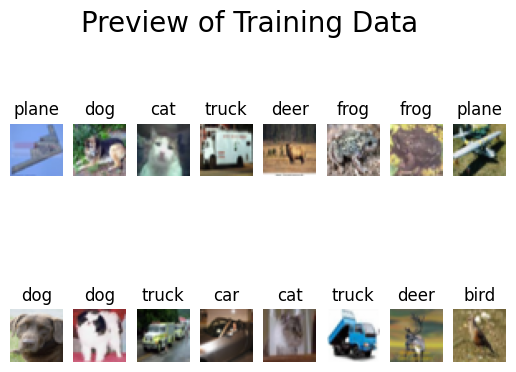

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5 # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.subplots_adjust(hspace=0.01)  # Adjust the value as needed
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

# Define a convolutional neural network
class Net(nn.Module):
    SLOPE = 0.01
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #init Conv2d
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

        # Initialize linear weights
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=Net.SLOPE)
        x = F.leaky_relu(self.fc2(x), negative_slope=Net.SLOPE)
        # x = F.softmax(self.fc3(x), dim=1)
        x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-6)
# Define the learning rate scheduler
## scheduler = ExponentialLR(optimizer, gamma=0.8)  # gamma controls the decay rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, threshold=1e-4, threshold_mode="abs", min_lr=1e-8)

# Load previously trained model
PATH = './cifar_net3.pth'
net.load_state_dict(torch.load(PATH))

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [14]:
from tqdm import tqdm

EPOCHS = 20
net.train()
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 
                                  desc=f"Epoch {epoch + 1} of {EPOCHS} / lr={scheduler.get_last_lr()[0]:.1e}",
                                  leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")
    scheduler.step(running_loss / len(trainloader))

# Save our trained model
torch.save(net.state_dict(), PATH)
print(" ... finished")

Training...


Epoch 1 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 214.20it/s]


Epoch 1, Loss: 1.1419844547462463


Epoch 2 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 212.43it/s]


Epoch 2, Loss: 1.1407965887069702


Epoch 3 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 214.20it/s]


Epoch 3, Loss: 1.139529062538147


Epoch 4 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 211.96it/s]


Epoch 4, Loss: 1.1380343574142455


Epoch 5 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 213.02it/s]


Epoch 5, Loss: 1.1368522771930694


Epoch 6 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 213.90it/s]


Epoch 6, Loss: 1.1353680504798889


Epoch 7 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 212.25it/s]


Epoch 7, Loss: 1.1344402879905702


Epoch 8 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 212.77it/s]


Epoch 8, Loss: 1.1329785185909271


Epoch 9 of 20 / lr=1.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 213.48it/s]


Epoch 9, Loss: 1.1318315866565705


Epoch 10 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 212.09it/s]


Epoch 10, Loss: 1.1306980483341218


Epoch 11 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 211.86it/s]


Epoch 11, Loss: 1.1294958423042298


Epoch 12 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 212.05it/s]


Epoch 12, Loss: 1.1282416532802582


Epoch 13 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.07it/s]


Epoch 13, Loss: 1.1268953411769866


Epoch 14 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 211.19it/s]


Epoch 14, Loss: 1.1257509251880646


Epoch 15 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 212.50it/s]


Epoch 15, Loss: 1.12430958029747


Epoch 16 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.27it/s]


Epoch 16, Loss: 1.1238005049991608


Epoch 17 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 213.23it/s]


Epoch 17, Loss: 1.1220680544376374


Epoch 18 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 211.66it/s]


Epoch 18, Loss: 1.1211051812362671


Epoch 19 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.03it/s]


Epoch 19, Loss: 1.1194756842422486


Epoch 20 of 20 / lr=1.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.26it/s]

Epoch 20, Loss: 1.118642699947357
 ... finished


# Step 4: Test the trained model

Let's test our model!

In [10]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.subplots_adjust(hspace=0.01)  # Adjust the value as needed
plt.show()

NameError: name 'Net' is not defined

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [15]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.4 %
Accuracy for class: car   is 65.9 %
Accuracy for class: bird  is 44.2 %
Accuracy for class: cat   is 40.4 %
Accuracy for class: deer  is 49.2 %
Accuracy for class: dog   is 46.8 %
Accuracy for class: frog  is 70.0 %
Accuracy for class: horse is 67.4 %
Accuracy for class: ship  is 72.8 %
Accuracy for class: truck is 69.3 %


## Step 6 - Inspect model


In [8]:
weights = net.fc3.weight
print(weights)


Parameter containing:
tensor([[-7.4676e-02,  1.5983e-01, -1.7989e-01, -1.9896e-01, -1.8312e-01,
         -1.9496e-01,  7.6753e-02, -1.4998e-01, -1.5127e-01, -3.1257e-02,
          6.9988e-02,  1.6520e-01, -2.5139e-01, -1.6666e-01, -7.7627e-02,
         -1.1160e-01, -5.0408e-02, -2.0359e-02,  2.4089e-01, -2.1008e-01,
          3.3154e-01, -1.7899e-01,  1.4563e-01, -2.0822e-01, -9.9894e-02,
          2.2210e-01,  1.9885e-01,  1.7958e-01,  6.9707e-02, -2.2891e-01,
          1.1011e-01,  2.4607e-01,  3.1625e-03,  3.2546e-01, -2.1509e-01,
         -1.1556e-01, -2.4999e-01,  5.5635e-02,  3.1173e-01, -1.0293e-01,
         -1.3996e-01, -1.2746e-01, -6.1953e-02, -2.1336e-01,  2.4143e-01,
          2.0030e-01, -2.1108e-01, -6.2597e-02, -2.6033e-01,  4.7310e-03,
         -9.0964e-02, -2.3025e-01, -1.4415e-01,  1.3389e-01,  8.1027e-02,
          1.3212e-01, -2.4636e-01, -1.1993e-01, -1.2426e-01,  1.7713e-01,
         -1.7666e-01,  6.2264e-02,  1.3843e-01,  1.1653e-01,  1.8656e-02,
         -1.7180